# fcHNN-based analyses of the ABIDE dataset

### Imports

In [2]:
import sys
sys.path.append('..')

import os
from os.path import join
import numpy as np
from nilearn.datasets.utils import _uncompress_file, _fetch_file
from nilearn.connectome import ConnectivityMeasure
import pandas as pd

import connattractor.network as network
import connattractor.analysis as analysis

import pickle

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")

from scipy.stats import binned_statistic_2d
from joblib import Parallel, delayed

%load_ext autoreload
%autoreload 1
%aimport connattractor.network
%aimport connattractor.analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Download data

We dowenload subject-specific timeseries signals extracted from
ABIDE preprocessed data as provided by the Preprocessed Connectome Project Initiative (PCP)
(http://preprocessed-connectomes-project.org/abide/index.html).

- n=866
    - autism 402
    - normal controls 464
    
    
These timeseries signals are provioded by Kalamaker Dadi et al. (2019), extracted using
pre-defined anatomical atlases such as AAL, Harvard Oxford and
pre-computed functional atlases such as Power, BASC and MODL (massive
online dictionary learning).

The sotware used for timeseries extraction, a Python library Nilearn
(http://nilearn.github.io/).

*Dadi K, Rahim M, Abraham A, Chyzhyk D, Milham M, Thirion B, Varoquaux G, Alzheimer's Disease Neuroimaging Initiative. Benchmarking functional connectome-based predictive models for resting-state fMRI. NeuroImage. 2019 May 15;192:115-34.*

In [2]:
data_dir = 'abide_data'

url = 'https://osf.io/hc4md/download'

# Download the zip file, first
dl_file = _fetch_file(url, data_dir=data_dir)

# Second, uncompress the downloaded zip file
_uncompress_file(dl_file, verbose=2)

Downloaded 1810186240 of 1811491701 bytes (99.9%,    0.3s remaining) ...done. (360 seconds, 5 min)
Extracting data from abide_data/download..... done.


## Download phenotypic data

```{warning}
Please review data usage agreements on
(http://preprocessed-connectomes-project.org/) before downloading the
phenotypic information.
```

In [3]:
pheno = _fetch_file('https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv',
            data_dir='abide_data')

## Define function to load timeseries data
From site NYU
### Exlcusion criteria: same as in the main analyses
- mean framewise displacement < 0.15
- percent scrubbed < 50%

In [4]:
_fd_thr = 0.15
_perc_scrub_thr = 50

def _get_paths(phenotypic, atlas, timeseries_dir):
    timeseries = []
    IDs_subject = []
    diagnosis = []
    subject_ids = phenotypic['SUB_ID']
    mean_fd = []
    num_fd = []
    perc_fd = []
    site = []
    for index, subject_id in enumerate(subject_ids):
        this_pheno = phenotypic[phenotypic['SUB_ID'] == subject_id]
        this_timeseries = join(timeseries_dir, atlas,
                               str(subject_id) + '_timeseries.txt')
        if os.path.exists(this_timeseries): # here filter based on data quality
            if this_pheno['func_mean_fd'].values[0] <= _fd_thr:
                if this_pheno['func_perc_fd'].values[0] <= _perc_scrub_thr:
                    if this_pheno['SITE_ID'].values[0]=='NYU':
                        timeseries.append(np.loadtxt(this_timeseries))
                        IDs_subject.append(subject_id)
                        diagnosis.append(this_pheno['DX_GROUP'].values[0])
                        mean_fd.append(this_pheno['func_mean_fd'].values[0])
                        num_fd.append(this_pheno['func_num_fd'].values[0])
                        perc_fd.append(this_pheno['func_perc_fd'].values[0])
                        site.append(this_pheno['SITE_ID'].values[0])
    return timeseries, diagnosis, IDs_subject, mean_fd, num_fd, perc_fd, site

## Load timeseries data

In [5]:
phenotypic = pd.read_csv('abide_data/Phenotypic_V1_0b_preprocessed1.csv').iloc[:,2:]
timeseries_, diagnosis, IDs_subject, mean_fd, num_fd, perc_fd, site = _get_paths(phenotypic, "BASC/networks", 'abide_data/')
sites, site_int = np.unique(site, return_inverse=True)
phenotypic.columns.values

array(['SUB_ID', 'X', 'subject', 'SITE_ID', 'FILE_ID', 'DX_GROUP',
       'DSM_IV_TR', 'AGE_AT_SCAN', 'SEX', 'HANDEDNESS_CATEGORY',
       'HANDEDNESS_SCORES', 'FIQ', 'VIQ', 'PIQ', 'FIQ_TEST_TYPE',
       'VIQ_TEST_TYPE', 'PIQ_TEST_TYPE', 'ADI_R_SOCIAL_TOTAL_A',
       'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 'ADI_R_ONSET_TOTAL_D',
       'ADI_R_RSRCH_RELIABLE', 'ADOS_MODULE', 'ADOS_TOTAL', 'ADOS_COMM',
       'ADOS_SOCIAL', 'ADOS_STEREO_BEHAV', 'ADOS_RSRCH_RELIABLE',
       'ADOS_GOTHAM_SOCAFFECT', 'ADOS_GOTHAM_RRB', 'ADOS_GOTHAM_TOTAL',
       'ADOS_GOTHAM_SEVERITY', 'SRS_VERSION', 'SRS_RAW_TOTAL',
       'SRS_AWARENESS', 'SRS_COGNITION', 'SRS_COMMUNICATION',
       'SRS_MOTIVATION', 'SRS_MANNERISMS', 'SCQ_TOTAL', 'AQ_TOTAL',
       'COMORBIDITY', 'CURRENT_MED_STATUS', 'MEDICATION_NAME',
       'OFF_STIMULANTS_AT_SCAN', 'VINELAND_RECEPTIVE_V_SCALED',
       'VINELAND_EXPRESSIVE_V_SCALED', 'VINELAND_WRITTEN_V_SCALED',
       'VINELAND_COMMUNICATION_STANDARD', 'VINELAND_PERSONAL_V_S

## Reorder timeseries data to reflect atlas modularity
The same procedure as in Spisak et al. 2020:

*Spisak T, Kincses B, Schlitt F, Zunhammer M, Schmidt-Wilcke T, Kincses ZT, Bingel U. Pain-free resting-state functional brain connectivity predicts individual pain sensitivity. Nature communications. 2020 Jan 10;11(1):187.*

In [6]:
order = pd.read_csv('../data_in/MIST122_relabeled.tsv', sep='\t').iloc[:, 1:]

timeseries = []
for idx in range(len(timeseries_)):
        ts = timeseries_[idx]
        #reorder columns in ts based on order['index']
        ts = ts[:, order['index'].values-1]
        timeseries.append(ts)

## Plot connectivity matrices

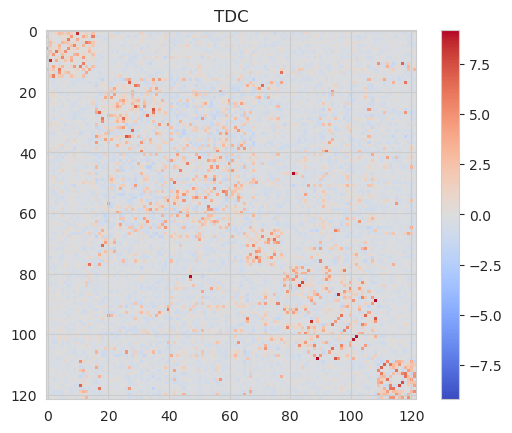

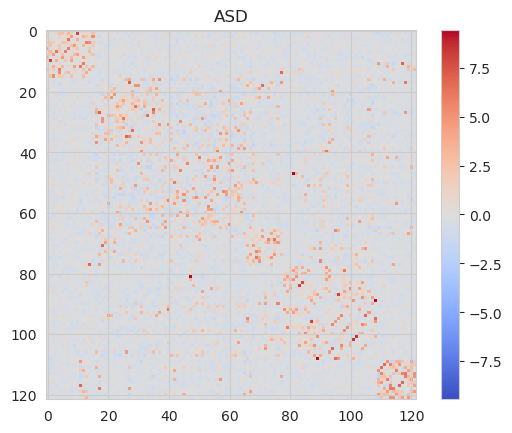

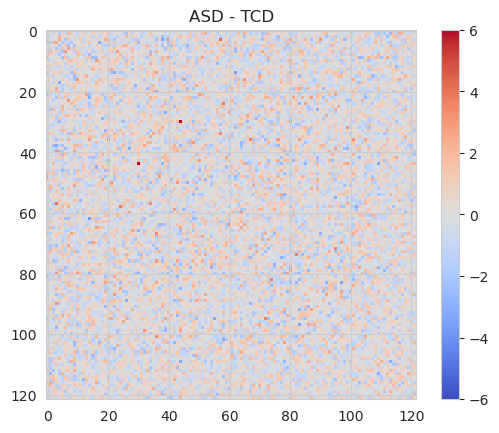

In [7]:
connections = ConnectivityMeasure(kind='partial correlation', vectorize=True, discard_diagonal=True)
idxs_ctr = np.where(np.array(diagnosis)==2)[0] # ctr
connections.fit_transform([timeseries[i] for i in idxs_ctr])
mtx_ctr = connections.mean_
hopnet = network.Hopfield(mtx_ctr, scale=True)
hopnet.plot_weights()
plt.title('TDC')
plt.show()

connections = ConnectivityMeasure(kind='partial correlation', vectorize=True, discard_diagonal=True)
idxs_asd = np.where(np.array(diagnosis)==1)[0] # asd
connections.fit_transform([timeseries[i] for i in idxs_asd])
mtx_asd = connections.mean_
hopnet = network.Hopfield(mtx_asd, scale=True)
hopnet.plot_weights()
plt.title('ASD')
plt.show()

hopnet = network.Hopfield(mtx_asd - mtx_ctr, scale=True)
hopnet.plot_weights()
plt.title('ASD - TCD')
plt.show()

### Group sizes after exclusions

In [8]:
len(idxs_asd), len(idxs_ctr)

(65, 95)

## Get pooled timeseries data for both groups

In [9]:
ts_ctr = np.vstack([timeseries[i] for i in idxs_ctr])
ts_asd = np.vstack([timeseries[i] for i in idxs_asd])

## Load the fcHNN template-embedding for visualization purposes

In [10]:
with open('../data_out/default_hopfield_embedding_0.37.pkl', 'rb') as file:
    hopfield_embedding = pickle.load(file)
    
# We can also visualize everything with the fcHNN projection generated from this study.
#noise = 0.37
#beta = 0.04
    
#simresults_all = analysis.simulate_activations(mtx_ctr, noise_coef=noise, 
#                                                          num_iter=100000, beta=0.04, random_state=42)
#hopfield_embeddings_all = analysis.create_embeddings(simresults_all, 
#                                                                attractor_sample=1000,random_state=42)

## Visualize the empirical timeseries data in the fcHNN-projection

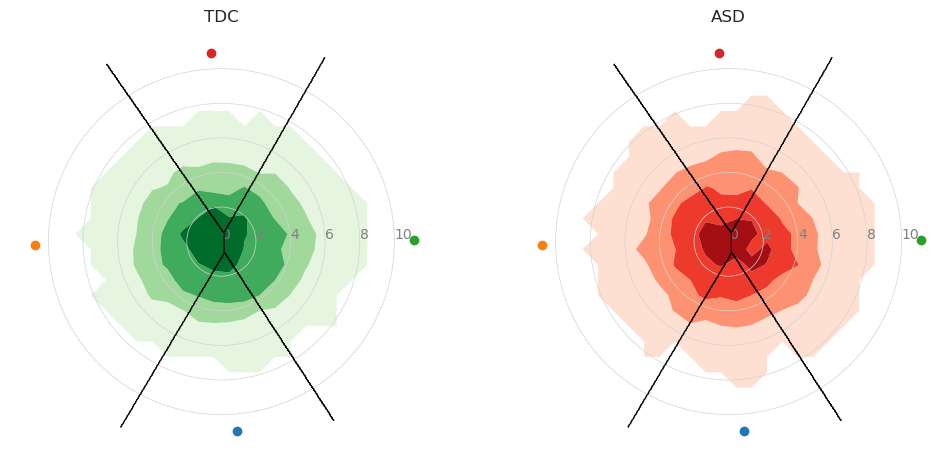

In [11]:
fig, axes = plt.subplots(ncols=2, subplot_kw={'projection': 'polar'}, figsize=(12, 6))

hopfield_embedding.plot(ts_ctr, plot_type='contourf', ax=axes[0],
                    density_bins=30, density_sigma=0, levels=3, alpha=1, cmap='Greens',
                    attractor_plot_type='scatter', attractor_kwargs=dict(alpha=1),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1, colors='black')
                   )
axes[0].set_title('TDC')
axes[0].set_xticks([])

hopfield_embedding.plot(ts_asd, plot_type='contourf', ax=axes[1],
                    density_bins=30, density_sigma=0, levels=3, alpha=1, cmap='Reds',
                    attractor_plot_type='scatter', attractor_kwargs=dict(alpha=1),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1, colors='black')
                   )
axes[1].set_title('ASD')
axes[1].set_xticks([])
plt.savefig('../data_out/fig/asd_projection.pdf')

In [12]:
from scipy.ndimage import gaussian_filter

def streamplot(projection1, projection2, max_r=None,
                             stream_bins=1, density_sigma=10, **kwargs):
    
    if max_r is None:
        max_r = np.max(np.abs(np.vstack((projection1, projection2))))
    print(max_r)
    
    default_kwargs = dict(linewidth=5, density=1.2)
    default_kwargs.update(kwargs)
    stream_linewidth = default_kwargs.pop('linewidth')
    
    bins = np.linspace(-max_r, max_r, stream_bins)
    
    directions1 = projection1[1:, :] - projection1[:-1, :]

    dir_x_1, x_edges, y_edges, _ = binned_statistic_2d(projection1[:-1, 1], projection1[:-1, 0], directions1[:, 0],
                                                    statistic=np.mean,
                                                    bins=[bins,bins])

    
    dir_y_1, x_edges, y_edges, _ = binned_statistic_2d(projection1[:-1, 1], projection1[:-1, 0], directions1[:, 1],
                                                    statistic=np.mean,
                                                    bins=[bins,bins])
    
    dir_x_1[np.isnan(dir_x_1)] = 0
    dir_y_1[np.isnan(dir_y_1)] = 0
    dir_x_1 = gaussian_filter(dir_x_1, sigma=density_sigma, mode='wrap')
    dir_y_1 = gaussian_filter(dir_y_1, sigma=density_sigma, mode='wrap')
    

    directions2 = projection2[1:, :] - projection2[:-1, :]

    dir_x_2, x_edges, y_edges, _ = binned_statistic_2d(projection2[:-1, 1], projection2[:-1, 0], directions2[:, 0],
                                                    statistic=np.mean,
                                                    bins=[bins,bins])
    dir_y_2, x_edges, y_edges, _ = binned_statistic_2d(projection2[:-1, 1], projection2[:-1, 0], directions2[:, 1],
                                                    statistic=np.mean,
                                                    bins=[bins,bins])
    
    dir_x_2[np.isnan(dir_x_2)] = 0
    dir_y_2[np.isnan(dir_y_2)] = 0
    dir_x_2 = gaussian_filter(dir_x_2, sigma=density_sigma, mode='wrap')
    dir_y_2 = gaussian_filter(dir_y_2, sigma=density_sigma, mode='wrap')
    
    density, x_edges, y_edges = np.histogram2d(projection2[:-1, 1], projection2[:-1, 0],
                                                     bins=[bins,bins],
                                                     density=True,
                                                     )
    
    x, y = np.meshgrid((x_edges[:-1] + x_edges[1:])/2,
                       (y_edges[:-1] + y_edges[1:])/2)
  
    
    dir_x = dir_x_2-dir_x_1
    dir_y = dir_y_2-dir_y_1

    
    
    speed = np.sqrt(dir_x ** 2 + dir_y ** 2)
    print('speed range:', np.min(speed), np.max(speed))

    ax = plt.streamplot(x, y, dir_x, dir_y,
                       linewidth= stream_linewidth * speed / speed[~ np.isnan(speed)].max(),
                       #color = density,
                      **default_kwargs)
    return ax, dir_x, dir_y, speed


## Predicted trajectory differences

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:50<00:00, 985.73it/s]


2
speed range: 0.0002976797902011011 0.03543000712709105


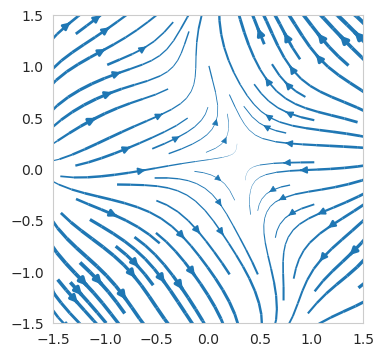

In [13]:
states_ctr = analysis.simulate_activations(mtx_ctr, noise_coef=0.37, scale=True,
                                                   num_iter=50000, beta=0.04, random_state=42).states
states_asd = analysis.simulate_activations(mtx_asd, noise_coef=0.37, scale=True,
                                                   num_iter=50000, beta=0.04, random_state=42).states

# Plot
# embed into the template projection
embedded_sim_ctr = hopfield_embedding.embedding_model.transform(states_ctr)
embedded_sim_asd = hopfield_embedding.embedding_model.transform(states_asd)


fig, ax = plt.subplots(figsize=(4, 4))
tmp, dir_sim_x, dir_sim_y, speed = streamplot(embedded_sim_ctr, embedded_sim_asd, max_r=2,
                                        stream_bins =100, density_sigma=10, density=1, linewidth=3, cmap='Reds')
ax.set_xlim((-1.5,1.5))
ax.set_ylim((-1.5,1.5))
ax.grid(False)
plt.savefig('../data_out/fig/asd_sim_trajectory.pdf')

## Empirical trajectory differences

2
speed range: 0.0010348906799668425 0.129518914952305


PearsonRResult(statistic=0.3019070322049977, pvalue=0.0)

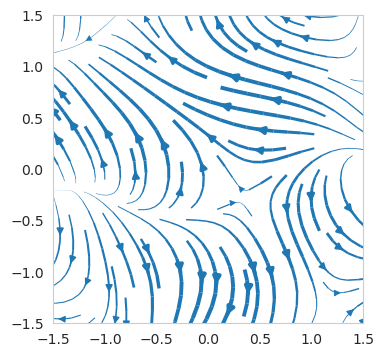

In [14]:
embedded_ctr = hopfield_embedding.embedding_model.transform(ts_ctr)
embedded_asd = hopfield_embedding.embedding_model.transform(ts_asd)

fig, ax = plt.subplots(figsize=(4, 4))
tmp, dir_emp_x, dir_emp_y, speed = streamplot(embedded_ctr, embedded_asd, max_r=2,
                                  stream_bins = 100, density_sigma=10, density=1, linewidth=3, cmap='Reds')

ax.set_xlim((-1.5,1.5))
ax.set_ylim((-1.5,1.5))
ax.grid(False)
plt.savefig('../data_out/fig/asd_emp_trajectory.pdf')
np.max(speed)

from scipy.stats import spearmanr, pearsonr
pearsonr(np.array([dir_sim_x, dir_sim_y]).flatten(), np.array([dir_emp_x, dir_emp_y]).flatten())

## Permutation test

Threshold: 0.2728008917122064
p =  0.033


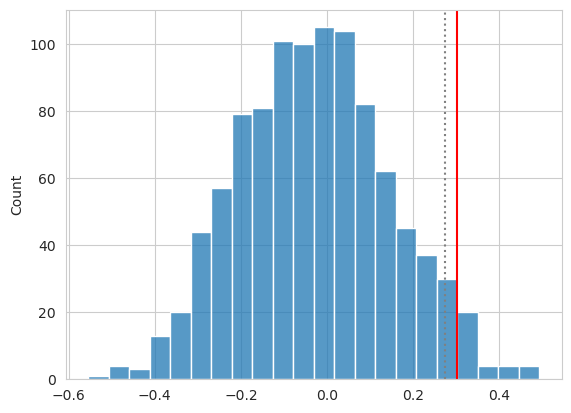

In [15]:
stream_bins = 100
max_r = 2
n_perm = 1000
density_sigma=10

def perm(seed):
    rng = np.random.default_rng(seed)
    permuted = rng.permutation(np.hstack((idxs_asd, idxs_ctr)))
    
    ts_1 = np.vstack([timeseries[i] for i in permuted[:len(idxs_ctr)]])
    ts_2 = np.vstack([timeseries[i] for i in permuted[len(idxs_ctr):]])
    
    projection1 = hopfield_embedding.embedding_model.transform(ts_1)
    projection2 = hopfield_embedding.embedding_model.transform(ts_2)
    
    bins = np.linspace(-max_r, max_r, stream_bins)
    
    directions1 = projection1[1:, :] - projection1[:-1, :]

    dir_x_1, x_edges, y_edges, _ = binned_statistic_2d(projection1[:-1, 1], projection1[:-1, 0], directions1[:, 0],
                                                    statistic=np.mean,
                                                    bins=[bins,bins])
    
    dir_y_1, x_edges, y_edges, _ = binned_statistic_2d(projection1[:-1, 1], projection1[:-1, 0], directions1[:, 1],
                                                    statistic=np.mean,
                                                    bins=[bins,bins])
    
    dir_x_1[np.isnan(dir_x_1)] = 0
    dir_y_1[np.isnan(dir_y_1)] = 0
    dir_x_1 = gaussian_filter(dir_x_1, sigma=density_sigma, mode='wrap')
    dir_y_1 = gaussian_filter(dir_y_1, sigma=density_sigma, mode='wrap')
    
    directions2 = projection2[1:, :] - projection2[:-1, :]

    dir_x_2, x_edges, y_edges, _ = binned_statistic_2d(projection2[:-1, 1], projection2[:-1, 0], directions2[:, 0],
                                                    statistic=np.mean,
                                                    bins=[bins,bins])
    dir_y_2, x_edges, y_edges, _ = binned_statistic_2d(projection2[:-1, 1], projection2[:-1, 0], directions2[:, 1],
                                                    statistic=np.mean,
                                                    bins=[bins,bins])
    
    dir_x_2[np.isnan(dir_x_2)] = 0
    dir_y_2[np.isnan(dir_y_2)] = 0
    dir_x_2 = gaussian_filter(dir_x_2, sigma=density_sigma, mode='wrap')
    dir_y_2 = gaussian_filter(dir_y_2, sigma=density_sigma, mode='wrap')
    
    dir_x = dir_x_2-dir_x_1
    dir_y = dir_y_2-dir_y_1  
    
    return pearsonr(np.array([dir_sim_x, dir_sim_y]).flatten(), np.array([dir_x, dir_y]).flatten())[0]
    
    
# set n_jobs=-1 to speed up
corrs = np.array(Parallel(n_jobs=1)(delayed(perm)(seed) for seed in np.arange(n_perm)))
    
sns.histplot(corrs)

fwer_threshold = np.quantile(corrs[~np.isnan(corrs)], 0.95)

print('Threshold:', fwer_threshold)
true_corr = pearsonr(np.array([dir_sim_x, dir_sim_y]).flatten(), np.array([dir_emp_x, dir_emp_y]).flatten())[0]
plt.axvline(fwer_threshold, color='gray', linestyle=':')
plt.axvline(true_corr, color='red')
print('p = ', np.sum(corrs>true_corr)/len(corrs))  

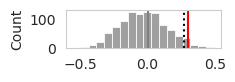

In [31]:
fig, ax = plt.subplots(figsize=(2, 0.5))
sns.histplot(corrs, color='gray', bins=18, ax=ax)
plt.axvline(0, color='gray')
plt.axvline(fwer_threshold, color='black', linestyle=':')
plt.axvline(true_corr, color='red')
ax.grid(False)
plt.savefig('../data_out/fig/hist_permtest_asd_sim.pdf')